# Drunk Detection Model

In [17]:
!pip install mtcnn

In [18]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from scipy import ndimage
from tqdm import tqdm
import time

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch import optim

import os
import tensorflow as tf
from tensorflow.keras import layers, models

#To upload from google drive
import zipfile

**Data Pre-Processing**

Prior to uploading our dataset of images of sober and intoxicated images, we centered the image around the subjects' faces and cropped the image to remove background noise using OpenCV.

In order to get the best results from OpenCV, the images we selected for our dataset were pictures of a singular person in an upright position without any masks, sunglasses, or any other accessories that would block distinguishing features of the person's face.



In [19]:
from mtcnn import MTCNN
import cv2

def preprocess_image_with_mtcnn(image_path, output_size=(256, 256)):
    """
    Preprocesses an image by detecting and centering the face in the frame using MTCNN.

    Args:
        image_path (str): Path to the input image.
        output_size (tuple): Desired output size (width, height) of the processed image.

    Returns:
        processed_image (ndarray): The cropped and resized image centered around the face.
        success (bool): Indicates whether face detection was successful.
    """
    # Load the image
    image = cv2.imread(image_path)
    if image is None:
        raise FileNotFoundError(f"Image at path '{image_path}' not found.")

    # Convert image from BGR (OpenCV format) to RGB (required by MTCNN)
    rgb_image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Initialize the MTCNN detector
    detector = MTCNN()

    # Detect faces in the image
    faces = detector.detect_faces(rgb_image)

    if not faces:
        print("No face detected.")
        return None, None, False

    # Assuming the first detected face is the main subject
    face = faces[0]['box']  # Bounding box of the face
    x, y, w, h = face

    # Add padding around the face
    padding = int(0.3 * max(w, h))
    x1 = max(0, x - padding)
    y1 = max(0, y - padding)
    x2 = min(image.shape[1], x + w + padding)
    y2 = min(image.shape[0], y + h + padding)

    # Crop the image
    cropped_image = image[y1:y2, x1:x2]

    # Resize to desired output size
    processed_image = cv2.resize(cropped_image, output_size, interpolation=cv2.INTER_AREA)
    original_image = rgb_image
    return original_image, processed_image, True

In [ ]:
# Example usage
input_image_path = "drunk.jpg"
output_image_path = "output_image.jpg"

original_image, processed_image, success = preprocess_image_with_mtcnn(input_image_path)
if success:
    cv2.imwrite(output_image_path, processed_image)
    print(f"Processed image saved at {output_image_path}.")

    #Print original image
    plt.subplot(1, 2, 1)
    plt.imshow(original_image)
    plt.title("Original Image")
    plt.axis("off")
    #Print processed image
    plt.subplot(1, 2, 2)
    plt.imshow(cv2.cvtColor(processed_image, cv2.COLOR_BGR2RGB))
    plt.title("Processed Image")
    plt.axis("off")
else:
    print("Face detection failed.")

FileNotFoundError: Image at path 'drunk.jpg' not found.

**Data Upload**

Here, we will upload our datasets of images of people to use for training and validation for our drunk detection model.

We have a dataset of 2608 images of [intoxicated faces](https://universe.roboflow.com/new-workspace-8swzs/drunk) and another dataset of 2128 images of [sober faces](https://susanqq.github.io/UTKFace/). We used these datasets as they have similar image quality to reduce as much bias as possible in the classification.


In [21]:
#dataset has 2 folders of dataset/sober and dataset/intoxicated
zip_path = "dataset.zip"

extract_dir = os.getcwd()
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)

extract_dir += "/"
print("Files extracted to:", extract_dir)

Files extracted to: /content/


In [22]:
for root, dirs, files in os.walk(extract_dir):
    print(f"Directory: {root}, Files: {len(files)}")

Directory: /content/, Files: 1
Directory: /content/.config, Files: 8
Directory: /content/.config/configurations, Files: 1
Directory: /content/.config/logs, Files: 0
Directory: /content/.config/logs/2024.12.06, Files: 6
Directory: /content/.ipynb_checkpoints, Files: 0
Directory: /content/dataset, Files: 0
Directory: /content/dataset/intoxicated, Files: 2608
Directory: /content/dataset/sober, Files: 2128
Directory: /content/sample_data, Files: 6


In [13]:
def preprocess_dataset(dataset_dir, output_size=(256, 256)):
    for root, _, files in os.walk(dataset_dir):
        for file in tqdm(files, desc=f"Processing images in {root}"):
            if file.lower().endswith(('.jpg', '.jpeg', '.png')):  # Process only image files
                file_path = os.path.join(root, file)

                # Preprocess the image
                _, processed_image, success = preprocess_image_with_mtcnn(file_path, output_size)
                if success:
                    # Replace the original image with the processed image
                    cv2.imwrite(file_path, cv2.cvtColor(processed_image, cv2.COLOR_RGB2BGR))
                else:
                    print(f"Skipping {file_path} due to face detection failure.")

preprocess_dataset(extract_dir)
print("Completed pre-processing")

Processing images in /content/.config: 100%|██████████| 8/8 [00:00<00:00, 68338.97it/s]
Processing images in /content/.config/configurations: 100%|██████████| 1/1 [00:00<00:00, 10837.99it/s]
Processing images in /content/.config/logs: 0it [00:00, ?it/s]
Processing images in /content/.config/logs/2024.12.06: 100%|██████████| 6/6 [00:00<00:00, 69905.07it/s]
Processing images in /content/.ipynb_checkpoints: 0it [00:00, ?it/s]
Processing images in /content/sample_data: 100%|██████████| 6/6 [00:00<00:00, 62446.21it/s]

Completed pre-processing


In [23]:
IMG_SIZE = (256, 256)
BATCH_SIZE = 32
train_ds = tf.keras.utils.image_dataset_from_directory(
    extract_dir,
    labels='inferred',  # Labels are inferred from folder names
    label_mode='int',   # Labels are integers (0 for sober, 1 for intoxicated)
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    validation_split=0.2,
    subset="training",
    seed=42  # Ensures reproducibility
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    extract_dir,
    labels='inferred',
    label_mode='int',
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    validation_split=0.2,
    subset="validation",
    seed=42
)

# Normalize pixel values to [0, 1]
def normalize(image, label):
    image = tf.cast(image, tf.float32) / 255.0
    return image, label

train_ds = train_ds.map(normalize)
val_ds = val_ds.map(normalize)

# Enable prefetching for performance
train_ds = train_ds.prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.prefetch(buffer_size=tf.data.AUTOTUNE)


Found 4736 files belonging to 2 classes.
Using 3789 files for training.
Found 4736 files belonging to 2 classes.
Using 947 files for validation.


**Model Architecture**


In [ ]:
def create_drunk_detection_model(input_shape):
    """
    Creates a CNN model for drunk detection.

    Args:
        input_shape (tuple): The shape of the input images (height, width, channels).

    Returns:
        tf.keras.Model: Compiled CNN model.
    """
    model = models.Sequential([
        # Convolutional layers
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(128, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(256, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),

        # Flatten and dense layers
        layers.Flatten(),
        layers.Dense(256, activation='relu'),
        layers.Dropout(0.5),  # Regularization to prevent overfitting
        layers.Dense(1, activation='sigmoid')  # Binary classification
    ])

    # Compile the model
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    return model

# Create the model
input_shape = (256, 256, 3)  # Image size defined earlier
model = create_drunk_detection_model(input_shape)

# Print the model summary
model.summary()


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 254, 254, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 127, 127, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 125, 125, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 62, 62, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 60, 60, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 30, 30, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 28, 28, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 14, 14, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 50176)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │      12,845,312 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │             257 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 13,233,985 (50.48 MB)

 Trainable params: 13,233,985 (50.48 MB)

 Non-trainable params: 0 (0.00 B)

**Training**

In [24]:
# Callback to monitor individual batch data
class BatchMetricsLogger(tf.keras.callbacks.Callback):
    def __init__(self):
        super().__init__()
        self.train_batch_losses = []
        self.train_batch_accuracies = []
        self.val_batch_losses = []
        self.val_batch_accuracies = []

    def on_train_batch_end(self, batch, logs=None):
        self.train_batch_losses.append(logs['loss'])
        self.train_batch_accuracies.append(logs['accuracy'])

    def on_test_batch_end(self, batch, logs=None):
        self.val_batch_losses.append(logs['loss'])
        self.val_batch_accuracies.append(logs['accuracy'])

In [30]:
# Define callbacks
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)

batch_metrics = BatchMetricsLogger()


# Train the model
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=3,
    callbacks=[early_stopping, batch_metrics]
)

# Evaluate the model on the validation dataset
val_loss, val_accuracy = model.evaluate(val_ds, verbose=2)
print(f"Validation Accuracy: {val_accuracy * 100:.2f}%")

model.save("drunk_detection_model.h5")

Epoch 1/3


Exception ignored in: <function ZipFile.__del__ at 0x7a4a4f28a8c0>
Traceback (most recent call last):
  File "/usr/lib/python3.10/zipfile.py", line 1832, in __del__
    def __del__(self):
KeyboardInterrupt: 


  3/119 ━━━━━━━━━━━━━━━━━━━━ 5:06 3s/step - accuracy: 0.6076 - loss: 0.6311

KeyboardInterrupt: 

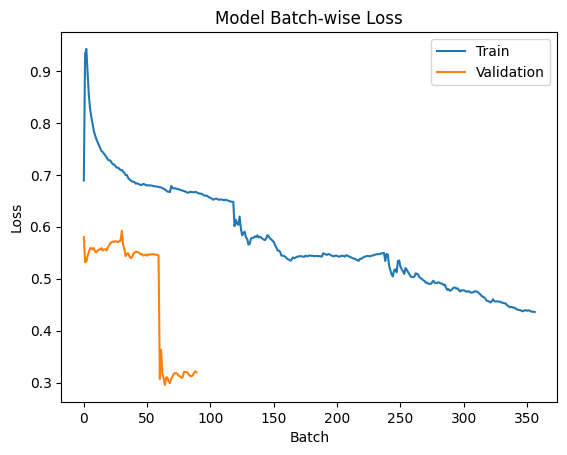

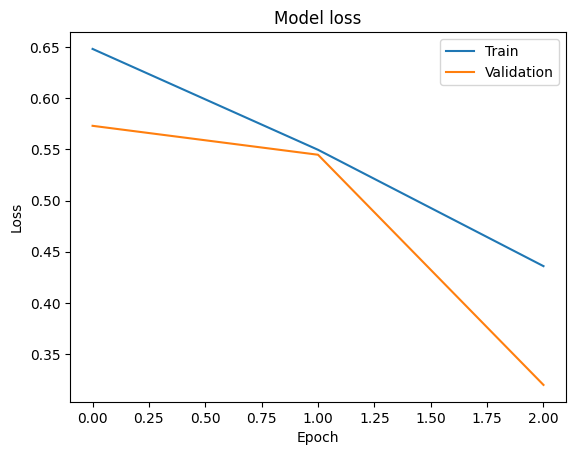

In [ ]:
# Loss v Batch
plt.figure()
plt.plot(batch_metrics.train_batch_losses)
plt.plot(batch_metrics.val_batch_losses)
plt.title('Model Batch-wise Loss')
plt.xlabel('Batch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

# Loss v Epoch
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

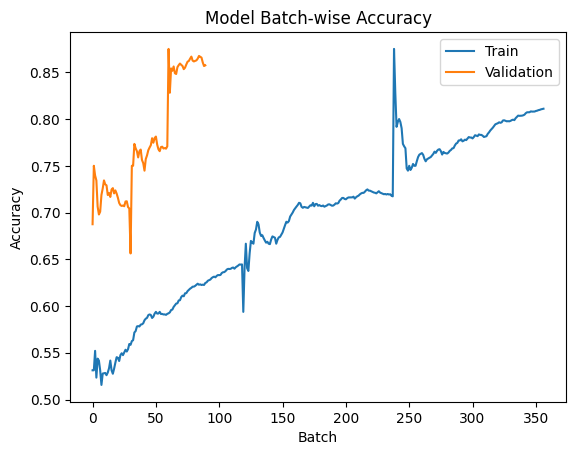

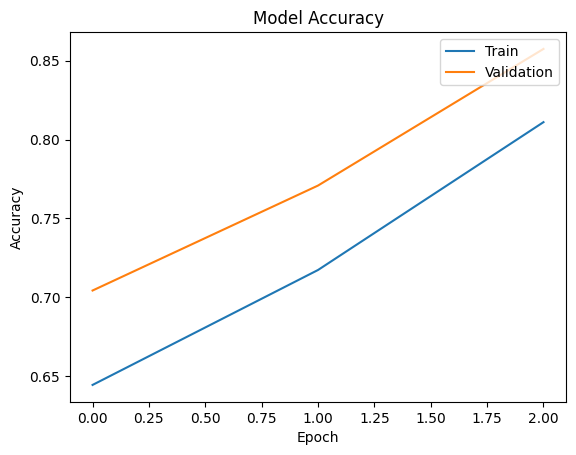

In [ ]:
# Accuracy v Batch
plt.plot(batch_metrics.train_batch_accuracies)
plt.plot(batch_metrics.val_batch_accuracies)
plt.title('Model Batch-wise Accuracy')
plt.xlabel('Batch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

# Accuracy v Epoch
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

In [31]:
mobile = tf.keras.applications.mobilenet.MobileNet()
mobile.summary()
extract_dir = os.getcwd()
extract_dir += "/dataset"

Model: "mobilenet_1.00_224"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1 (Conv2D)                       │ (None, 112, 112, 32)        │             864 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1_bn (BatchNormalization)        │ (None, 112, 112, 32)        │             128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1_relu (ReLU)                    │ (None, 112, 112, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_1 (DepthwiseConv2D)          │ (None, 112, 112, 32)        │             288 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_1_bn (BatchNormalization)    │ (None, 112, 112, 32)        │             128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_1_relu (ReLU)                │ (None, 112, 112, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_1 (Conv2D)                   │ (None, 112, 112, 64)        │           2,048 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_1_bn (BatchNormalization)    │ (None, 112, 112, 64)        │             256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_1_relu (ReLU)                │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pad_2 (ZeroPadding2D)           │ (None, 113, 113, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_2 (DepthwiseConv2D)          │ (None, 56, 56, 64)          │             576 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_2_bn (BatchNormalization)    │ (None, 56, 56, 64)          │             256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_2_relu (ReLU)                │ (None, 56, 56, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_2 (Conv2D)                   │ (None, 56, 56, 128)         │           8,192 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_2_bn (BatchNormalization)    │ (None, 56, 56, 128)         │             512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_2_relu (ReLU)                │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_3 (DepthwiseConv2D)          │ (None, 56, 56, 128)         │           1,152 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_3_bn (BatchNormalization)    │ (None, 56, 56, 128)         │             512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_3_relu (ReLU)                │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_3 (Conv2D)                   │ (None, 56, 56, 128)         │          16,384 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 4,253,864 (16.23 MB)

 Trainable params: 4,231,976 (16.14 MB)

 Non-trainable params: 21,888 (85.50 KB)

In [37]:
x = mobile.layers[-5].output
x = tf.keras.layers.Reshape(target_shape=(1024,))(x)
output = layers.Dense(1, activation='sigmoid')(x)
model = models.Model(inputs=mobile.input, outputs=output)

In [38]:
for layer in model.layers[:-10]:
    layer.trainable = False

In [39]:
IMG_SIZE = (224, 224)
BATCH_SIZE = 32

train_ds = tf.keras.utils.image_dataset_from_directory(
    extract_dir,
    labels='inferred',  # Labels are inferred from folder names
    label_mode='int',   # Labels are integers (0 for sober, 1 for intoxicated)
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    validation_split=0.2,
    subset="training",
    seed=42  # Ensures reproducibility
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    extract_dir,
    labels='inferred',
    label_mode='int',
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    validation_split=0.2,
    subset="validation",
    seed=42
)

# Normalize pixel values to [0, 1]
def normalize(image, label):
    image = tf.cast(image, tf.float32) / 255.0
    return image, label

train_ds = train_ds.map(normalize)
val_ds = val_ds.map(normalize)

# Enable prefetching for performance
train_ds = train_ds.prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.prefetch(buffer_size=tf.data.AUTOTUNE)

Found 4736 files belonging to 2 classes.
Using 3789 files for training.
Found 4736 files belonging to 2 classes.
Using 947 files for validation.


In [40]:
batch_metrics2 = BatchMetricsLogger()
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=2,
    callbacks=[early_stopping, batch_metrics2]
)

Epoch 1/2
119/119 ━━━━━━━━━━━━━━━━━━━━ 248s 2s/step - accuracy: 0.9313 - loss: 0.1618 - val_accuracy: 0.8152 - val_loss: 0.6701
Epoch 2/2
119/119 ━━━━━━━━━━━━━━━━━━━━ 235s 2s/step - accuracy: 0.9817 - loss: 0.0423 - val_accuracy: 0.9092 - val_loss: 0.3217


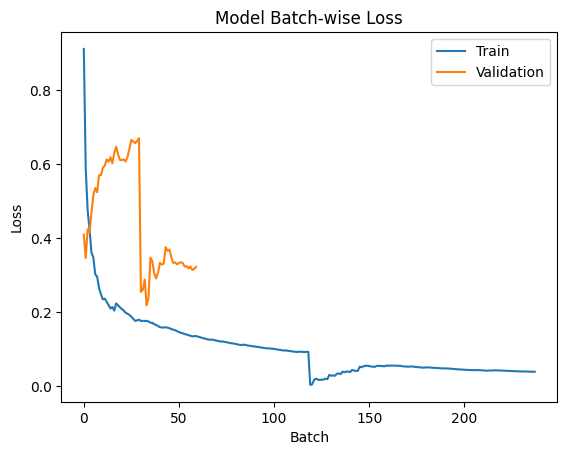

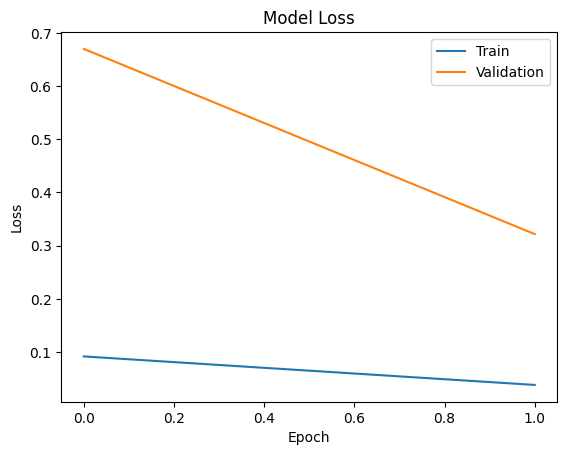

In [41]:
# Loss v Batch
plt.figure()
plt.plot(batch_metrics2.train_batch_losses)
plt.plot(batch_metrics2.val_batch_losses)
plt.title('Model Batch-wise Loss')
plt.xlabel('Batch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

# Loss v Epoch
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

In [ ]:
!zip -r dataset.zip dataset/
from google.colab import files
files.download('dataset.zip')

  adding: dataset/ (stored 0%)
  adding: dataset/intoxicated/ (stored 0%)
  adding: dataset/intoxicated/Drunkface357B_jpg.rf.b74db004fa75570c1a7602186320b3ce(1).jpg (deflated 1%)
  adding: dataset/intoxicated/Drunkface575B_jpg.rf.b292834cdb3b898a384c6b048da47d8f.jpg (deflated 1%)
  adding: dataset/intoxicated/Drunkface51B_png.rf.232c328750f32bcb52e7377a76e718ca.jpg (deflated 1%)
  adding: dataset/intoxicated/Drunkface81B1_jpeg.rf.3f40d267f8e05401849db74203ea22d0.jpg (deflated 1%)
  adding: dataset/intoxicated/Drunkface386B3_jpg.rf.0fc18ee2e9c1d37ab1c203f638969b03.jpg (deflated 1%)
  adding: dataset/intoxicated/Drunkface164B1_jpg.rf.42e7834bab096fc4b8d56a184ffa5ab9.jpg (deflated 1%)
  adding: dataset/intoxicated/Drunkface16B_JPG.rf.d146ce0dc1cf9eee4012a1f666e4ac96.jpg (deflated 1%)
  adding: dataset/intoxicated/Drunkface268B3_jpg.rf.015d3df2abf00c353d32a54ab6d525b7.jpg (deflated 1%)
  adding: dataset/intoxicated/Drunkface185B2_jpg.rf.2929edc6fe6847e9b880a0ab735e5d59.jpg (deflated 1%)
  

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

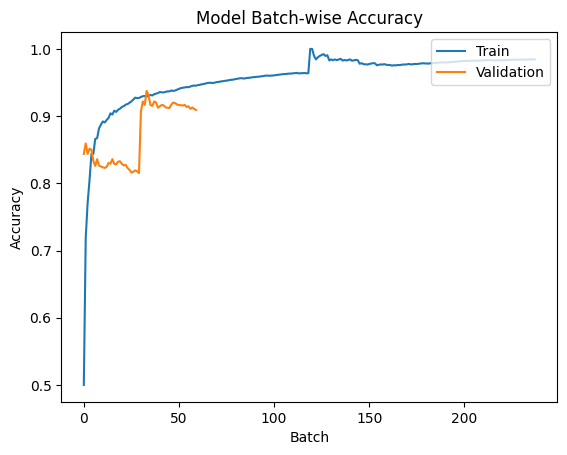

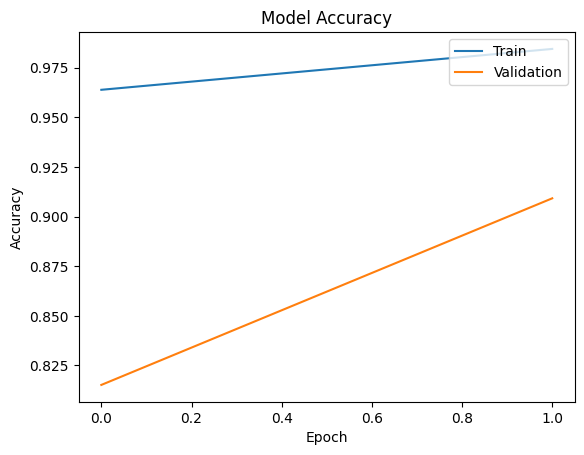

In [42]:
# Accuracy v Batch
plt.plot(batch_metrics2.train_batch_accuracies)
plt.plot(batch_metrics2.val_batch_accuracies)
plt.title('Model Batch-wise Accuracy')
plt.xlabel('Batch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

# Accuracy v Epoch
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

In [44]:
val_outs = model.predict(val_ds)

30/30 ━━━━━━━━━━━━━━━━━━━━ 40s 1s/step


TypeError: fromiter() missing required argument 'dtype' (pos 2)